# pySCENIC protocol: sunhye 2nd experiment

June 2020

Dataset: 2nd experiment from SHL

This notebook uses a loom file generated from the first part of the SCENIC protocol, described in: [PBMC10k_SCENIC-protocol-CLI.ipynb](https://github.com/aertslab/SCENICprotocol/blob/master/notebooks/PBMC10k_SCENIC-protocol-CLI.ipynb)

In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
# from scanpy.plotting._tools.scatterplots import plot_scatter
import seaborn as sns

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.manifold.t_sne module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.manifold. Anything that cannot be imported from sklearn.manifold is now part of the private API.
  warnings.warn(message, FutureWarning)


#### set variables for file paths to read from and write to:

In [2]:
# set a working directory
wdir = '/home/skevin/single_cell_projects/sc_RB_devel/20171031-SHL-FACS-Hs_proj/'
os.chdir( wdir )
os.getcwd()

'/dataVolume/storage/single_cell_projects/sc_RB_devel/20171031-SHL-FACS-Hs_proj'

In [3]:
# path to loom output, generated from a combination of Scanpy and pySCENIC results:
loom_file = 'output/scenic/ctrl_seu-final.loom'

adata_file = loom_file.replace("-final.loom", ".h5ad")
# adata_file = 'output/scenic/allfeatures_only_pt_w_ctrl_seu.h5ad'



In [5]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.logging.print_versions()
sc.settings.set_figure_params(dpi=150)

## Extract relevant data from the integrated loom file

In [6]:
# scenic output
lf = lp.connect( loom_file, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [7]:
thresholds = {}
for i in meta['regulonThresholds']:
    j=i['regulon']
#     print(j)
    thresholds[j] = i['defaultThresholdValue']

In [8]:
# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

In [9]:
# capture embeddings:
dr = [
    pd.DataFrame( lf.ca.Embedding, index=lf.ca.CellID )
]
dr_names = [
    meta['embeddings'][0]['name'].replace(" ","_")
]

# add other embeddings
drx = pd.DataFrame( lf.ca.Embeddings_X, index=lf.ca.CellID )
dry = pd.DataFrame( lf.ca.Embeddings_Y, index=lf.ca.CellID )

for i in range( len(drx.columns) ):
    dr.append( pd.concat( [ drx.iloc[:,i], dry.iloc[:,i] ], sort=False, axis=1, join='outer' ))
    dr_names.append( meta['embeddings'][i+1]['name'].replace(" ","_").replace('/','-') )

# rename columns:
for i,x in enumerate( dr ):
    x.columns = ['X','Y']

In [10]:
lf.close()

# find gene length of regulons

## query n genes in any regulon

In [11]:
regulons.keys()

dict_keys(['CREB3_(+)', 'CREM_(+)', 'EGR1_(+)', 'FOS_(+)', 'IRF9_(+)', 'KDM5B_(+)', 'NEUROD1_(+)', 'NFE2L2_(+)', 'NR2F6_(+)', 'NRL_(+)', 'RXRG_(+)', 'SOX4_(+)', 'SP3_(+)', 'YBX1_(+)', 'ZNF160_(+)'])

In [12]:
myregulon = 'NRL_(+)'

regulon_length = len(regulons[myregulon])
f"There are {regulon_length} genes in {myregulon}."

'There are 20 genes in NRL_(+).'

## distribution of number of genes per regulon

In [13]:
import numpy as np

ncells = {key: len(value) for key, value in regulons.items()}

pd.Series([*ncells.values()]).describe()
# np.min(ncells.values())
# length_key = length_dict['key']  # length of the list stored at `'key'` ...

count    15.000000
mean     18.333333
std      12.641579
min       4.000000
25%      10.500000
50%      15.000000
75%      23.000000
max      48.000000
dtype: float64

### Alternately, we can load this data into a `scanpy.AnnData` object

This can be done directly from the integrated loom file, with a few modifications to allow for SCENIC- and SCope-specific loom attributes:

In [14]:
adata = sc.read( loom_file, validate=False)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [15]:
# drop the embeddings and extra attributes from the obs object
adata.obs.drop( ['Embedding','Embeddings_X','Embeddings_Y','RegulonsAUC'], axis=1, inplace=True )

In [16]:
# add the embeddings into the adata.obsm object
for i,x in enumerate( dr ):
    adata.obsm[ 'X_'+dr_names[i] ] = x.values

In [17]:
sc._utils.sanitize_anndata( adata )

... storing 'ClusterID' as categorical
... storing 'Clusterings' as categorical
... storing 'Louvain_clusters_Scanpy' as categorical
... storing 'Phase' as categorical
... storing 'batch' as categorical
... storing 'branch' as categorical
... storing 'clusters_0.2' as categorical
... storing 'clusters_0.4' as categorical
... storing 'clusters_0.6' as categorical
... storing 'clusters_0.8' as categorical
... storing 'clusters_1' as categorical
... storing 'clusters_1.2' as categorical
... storing 'clusters_1.4' as categorical
... storing 'clusters_1.6' as categorical
... storing 'clusters_1.8' as categorical
... storing 'clusters_2' as categorical
... storing 'custom_cluster' as categorical
... storing 'day' as categorical
... storing 'excluded_because' as categorical
... storing 'gene_snn_res.0.2' as categorical
... storing 'gene_snn_res.0.4' as categorical
... storing 'gene_snn_res.0.6' as categorical
... storing 'gene_snn_res.0.8' as categorical
... storing 'gene_snn_res.1' as catego

In [19]:
adata_h5ad = sc.read(adata_file)

metadata = adata_h5ad.obs

In [20]:
adata_h5ad

AnnData object with n_obs × n_vars = 152 × 56267
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sample_ID', 'day', 'treatment_group', 'index_i7', 'i7_bases', 'index_i5', 'i5_bases', 'lane', 'branch', 'custom_cluster', 'batch', 'gene_snn_res.0.2', 'gene_snn_res.0.4', 'gene_snn_res.0.6', 'gene_snn_res.0.8', 'gene_snn_res.1', 'gene_snn_res.1.2', 'gene_snn_res.1.4', 'gene_snn_res.1.6', 'gene_snn_res.1.8', 'gene_snn_res.2', 'seurat_clusters', 'clusters_0.2', 'clusters_0.4', 'clusters_0.6', 'clusters_0.8', 'clusters_1', 'clusters_1.2', 'clusters_1.4', 'clusters_1.6', 'clusters_1.8', 'clusters_2', 'S.Score', 'G2M.Score', 'Phase', 'read_count', 'excluded_because', 'pt2_clusters', 'pt1_clusters', 'nCount_gene', 'nFeature_gene', 'nCount_transcript', 'nFeature_transcript', 'transcript_snn_res.0.2', 'transcript_snn_res.0.4', 'transcript_snn_res.0.6', 'transcript_snn_res.0.8', 'transcript_snn_res.1', 'transcript_snn_res.1.2', 'transcript_snn_res.1.4', 'transcript_snn_res.1.6', 'transcript_sn

In [22]:
adata.obs.columns

Index(['ClusterID', 'Clusterings', 'G2M.Score', 'Louvain_clusters_Scanpy',
       'Percent_mito', 'Phase', 'S.Score', 'Sample_ID', 'batch', 'branch',
       'clusters_0.2', 'clusters_0.4', 'clusters_0.6', 'clusters_0.8',
       'clusters_1', 'clusters_1.2', 'clusters_1.4', 'clusters_1.6',
       'clusters_1.8', 'clusters_2', 'custom_cluster', 'day',
       'excluded_because', 'gene_snn_res.0.2', 'gene_snn_res.0.4',
       'gene_snn_res.0.6', 'gene_snn_res.0.8', 'gene_snn_res.1',
       'gene_snn_res.1.2', 'gene_snn_res.1.4', 'gene_snn_res.1.6',
       'gene_snn_res.1.8', 'gene_snn_res.2', 'i5_bases', 'i7_bases',
       'index_i5', 'index_i7', 'lane', 'louvain', 'nCount_RNA', 'nCount_gene',
       'nCount_transcript', 'nFeature_RNA', 'nFeature_gene',
       'nFeature_transcript', 'nGene', 'nUMI', 'n_counts', 'n_genes',
       'orig.ident', 'percent_mito', 'pt1_clusters', 'pt2_clusters',
       'read_count', 'seurat_clusters', 'transcript_snn_res.0.2',
       'transcript_snn_res.0.4', 't

In [23]:
# cell annotations from the anndata column attributes:
cellAnnot = adata.obs

#### We can also add all metadata derived from SCENIC to the `scanpy.AnnData` object.

In [24]:
# # load the regulons from a file using the load_signatures function
# sig = load_signatures('reg.csv')
# adata = add_scenic_metadata(adata, auc_mtx, sig)

---
## Display a motifs table with motif logos

#### View the motifs table along with motif logos

In [25]:
# # helper functions (not yet integrated into pySCENIC):

# from pyscenic.utils import load_motifs
# import operator as op
# from IPython.display import HTML, display

# BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
# COLUMN_NAME_LOGO = "MotifLogo"
# COLUMN_NAME_MOTIF_ID = "MotifID"
# COLUMN_NAME_TARGETS = "TargetGenes"

# def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
#     """
#     :param df:
#     :param base_url:
#     """
#     # Make sure the original dataframe is not altered.
#     df = df.copy()
    
#     # Add column with URLs to sequence logo.
#     def create_url(motif_id):
#         return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
#     df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
#     # Truncate TargetGenes.
#     def truncate(col_val):
#         return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
#     df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
#     MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
#     pd.set_option('display.max_colwidth', 200)
#     display(HTML(df.head().to_html(escape=False)))
#     pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [26]:
# df_motifs = load_motifs('reg.csv')

In [27]:
# selected_motifs = ['PAX5','TCF3','EBF1']
# df_motifs_sel = df_motifs.iloc[ [ True if x in selected_motifs else False for x in df_motifs.index.get_level_values('TF') ] ,:]

In [28]:
# #display_logos(df_motifs.head())
# display_logos( df_motifs_sel.sort_values([('Enrichment','NES')], ascending=False).head(9))

---
# Dimensionality reduction plots

### Alternately, we can plot two dimensionality reductions side-by-side

(this uses non-Scanpy plotting functions)

In [29]:
def colorMap( x, palette='bright' ):
    import natsort
    from collections import OrderedDict
    #
    n=len(set(x))
    cpalette = sns.color_palette(palette,n_colors=n )
    cdict = dict( zip( list(set(x)), cpalette ))
    cmap = [ cdict[i] for i in x ]
    cdict = OrderedDict( natsort.natsorted(cdict.items()) )
    return cmap,cdict

def drplot( dr, colorlab, ax, palette='bright', title=None, **kwargs ):
    cmap,cdict = colorMap( colorlab, palette )
    for lab,col in cdict.items():  
        ix = colorlab.loc[colorlab==lab].index
        ax.scatter( dr['X'][ix], dr['Y'][ix], c=[col]*len(ix), alpha=0.7, label=lab, edgecolors='none')
    if( title is not None ):
        ax.set_title(title, fontsize='x-large');
    #
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


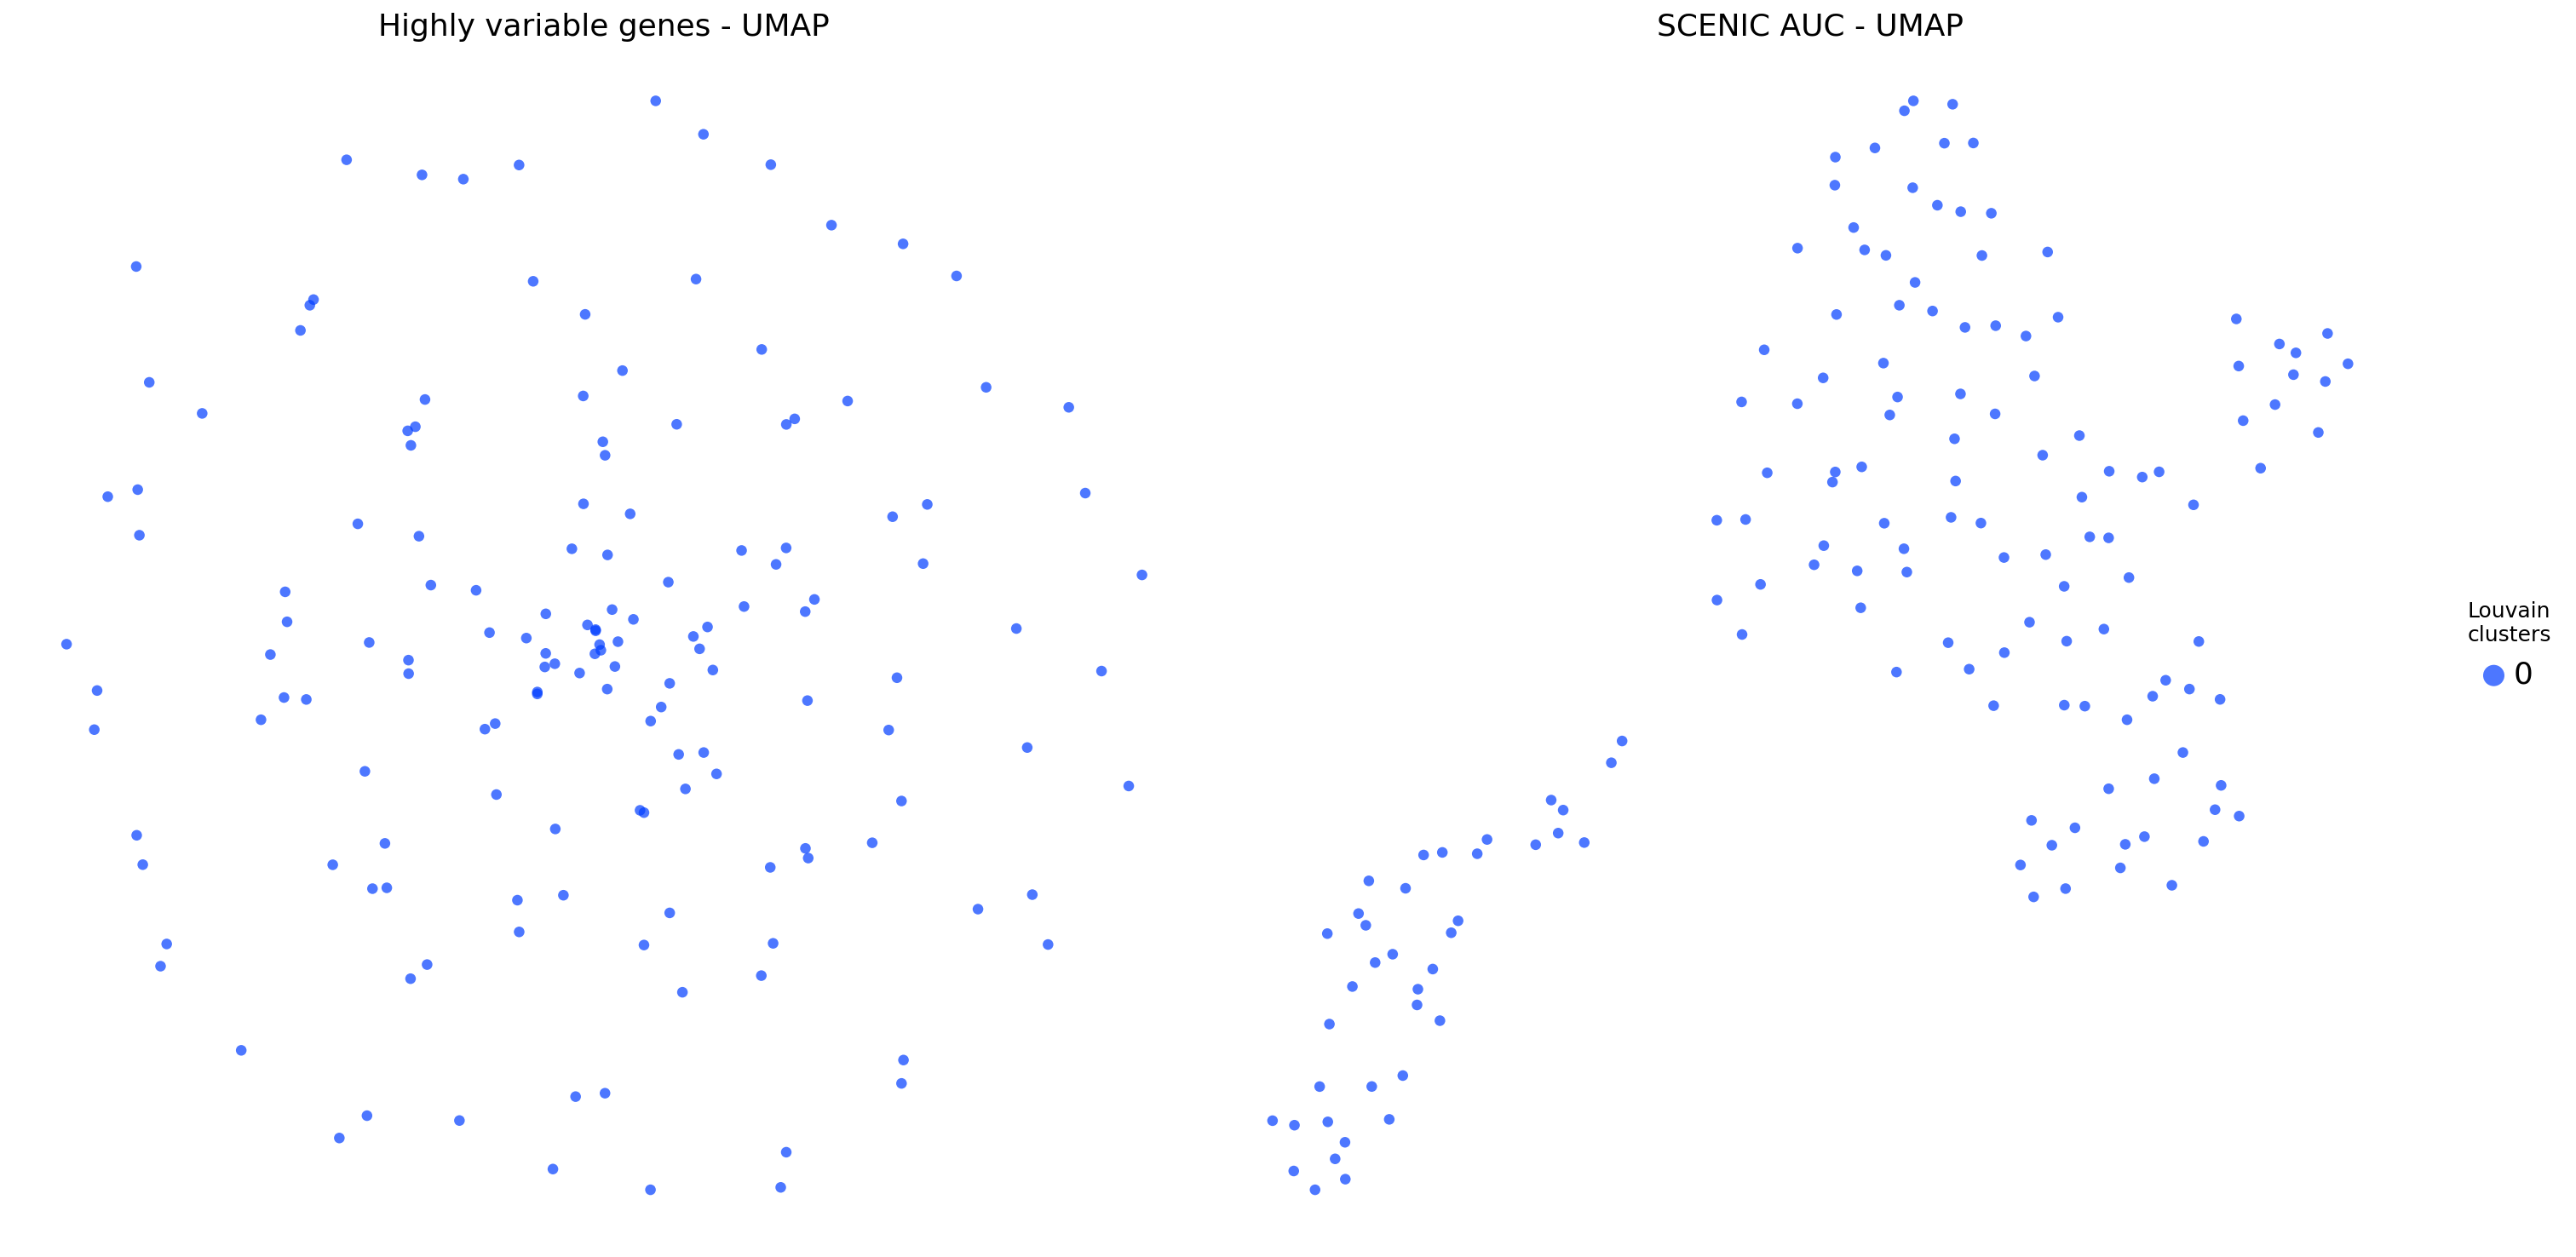

In [30]:
plt.rcParams.update({'font.size':12})

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10), dpi=150 )

drplot( dr[0], colorlab=cellAnnot['Louvain_clusters_Scanpy'], ax=ax1, palette='bright', s=2, title='Highly variable genes - UMAP' )

drplot( dr[4], colorlab=cellAnnot['Louvain_clusters_Scanpy'], ax=ax2, palette='bright', s=2, title='SCENIC AUC - UMAP' )
ax2.legend(loc='right', bbox_to_anchor=(1.15, 0.5), ncol=1, markerscale=2, fontsize='x-large', frameon=False, title="Louvain\nclusters")

plt.tight_layout()
plt.savefig("PBMC10k_dimred_umap-hvg-scenic-louvain.pdf", dpi=600, bbox_inches = "tight")

In [31]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

### RSS panel plot with all cell types

In [32]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

# Regulon specificity scores (RSS) across cell metadata

## Metadata = Louvain clusters at resolution 1.6

In [35]:
metavar="gene_snn_res.1.6"

### Calculate RSS

In [36]:
rss_louvain = regulon_specificity_scores( auc_mtx, cellAnnot[metavar] )
rss_louvain

,CREB3_(+),CREM_(+),EGR1_(+),FOS_(+),IRF9_(+),KDM5B_(+),NEUROD1_(+),NFE2L2_(+),NR2F6_(+),NRL_(+),RXRG_(+),SOX4_(+),SP3_(+),YBX1_(+),ZNF160_(+)
1,0.319754,0.311425,0.264864,0.192606,0.205388,0.297707,0.297173,0.279619,0.333558,0.290736,0.338919,0.293679,0.267664,0.335404,0.222224
3,0.351146,0.311431,0.304773,0.185680,0.249284,0.361997,0.317897,0.289274,0.378519,0.307011,0.397814,0.335156,0.278471,0.383545,0.218674
2,0.345013,0.362651,0.333381,0.212645,0.238462,0.317694,0.299647,0.254847,0.363415,0.287623,0.382811,0.325226,0.360857,0.367399,0.194443
0,0.354143,0.242926,0.304424,0.179300,0.297819,0.364915,0.437471,0.469381,0.298300,0.451346,0.243291,0.412182,0.359461,0.302448,0.194437
6,0.207773,0.181149,0.194588,0.175458,0.167445,0.207159,0.217991,0.218660,0.214002,0.216818,0.223845,0.210666,0.193892,0.213800,0.167445
4,0.227596,0.276517,0.211544,0.167445,0.233495,0.215361,0.213525,0.221170,0.224168,0.218613,0.227950,0.215822,0.215343,0.232148,0.167445
5,0.221441,0.176040,0.193515,0.167445,0.299749,0.241694,0.263734,0.307764,0.214627,0.282339,0.179951,0.250431,0.248129,0.206692,0.167445
8,0.191434,0.167445,0.171781,0.167445,0.167445,0.189265,0.183069,0.179259,0.184869,0.179309,0.179102,0.184529,0.190979,0.184810,0.167445
7,0.267108,0.249482,0.420846,0.565855,0.275181,0.263297,0.245650,0.240472,0.274284,0.246825,0.280360,0.261876,0.230823,0.257895,0.167445


In [37]:
rss_louvain.to_csv('output/scenic/RSS_specificity_scores.csv', index = False)

### RSS panel plot with all louvain clusters

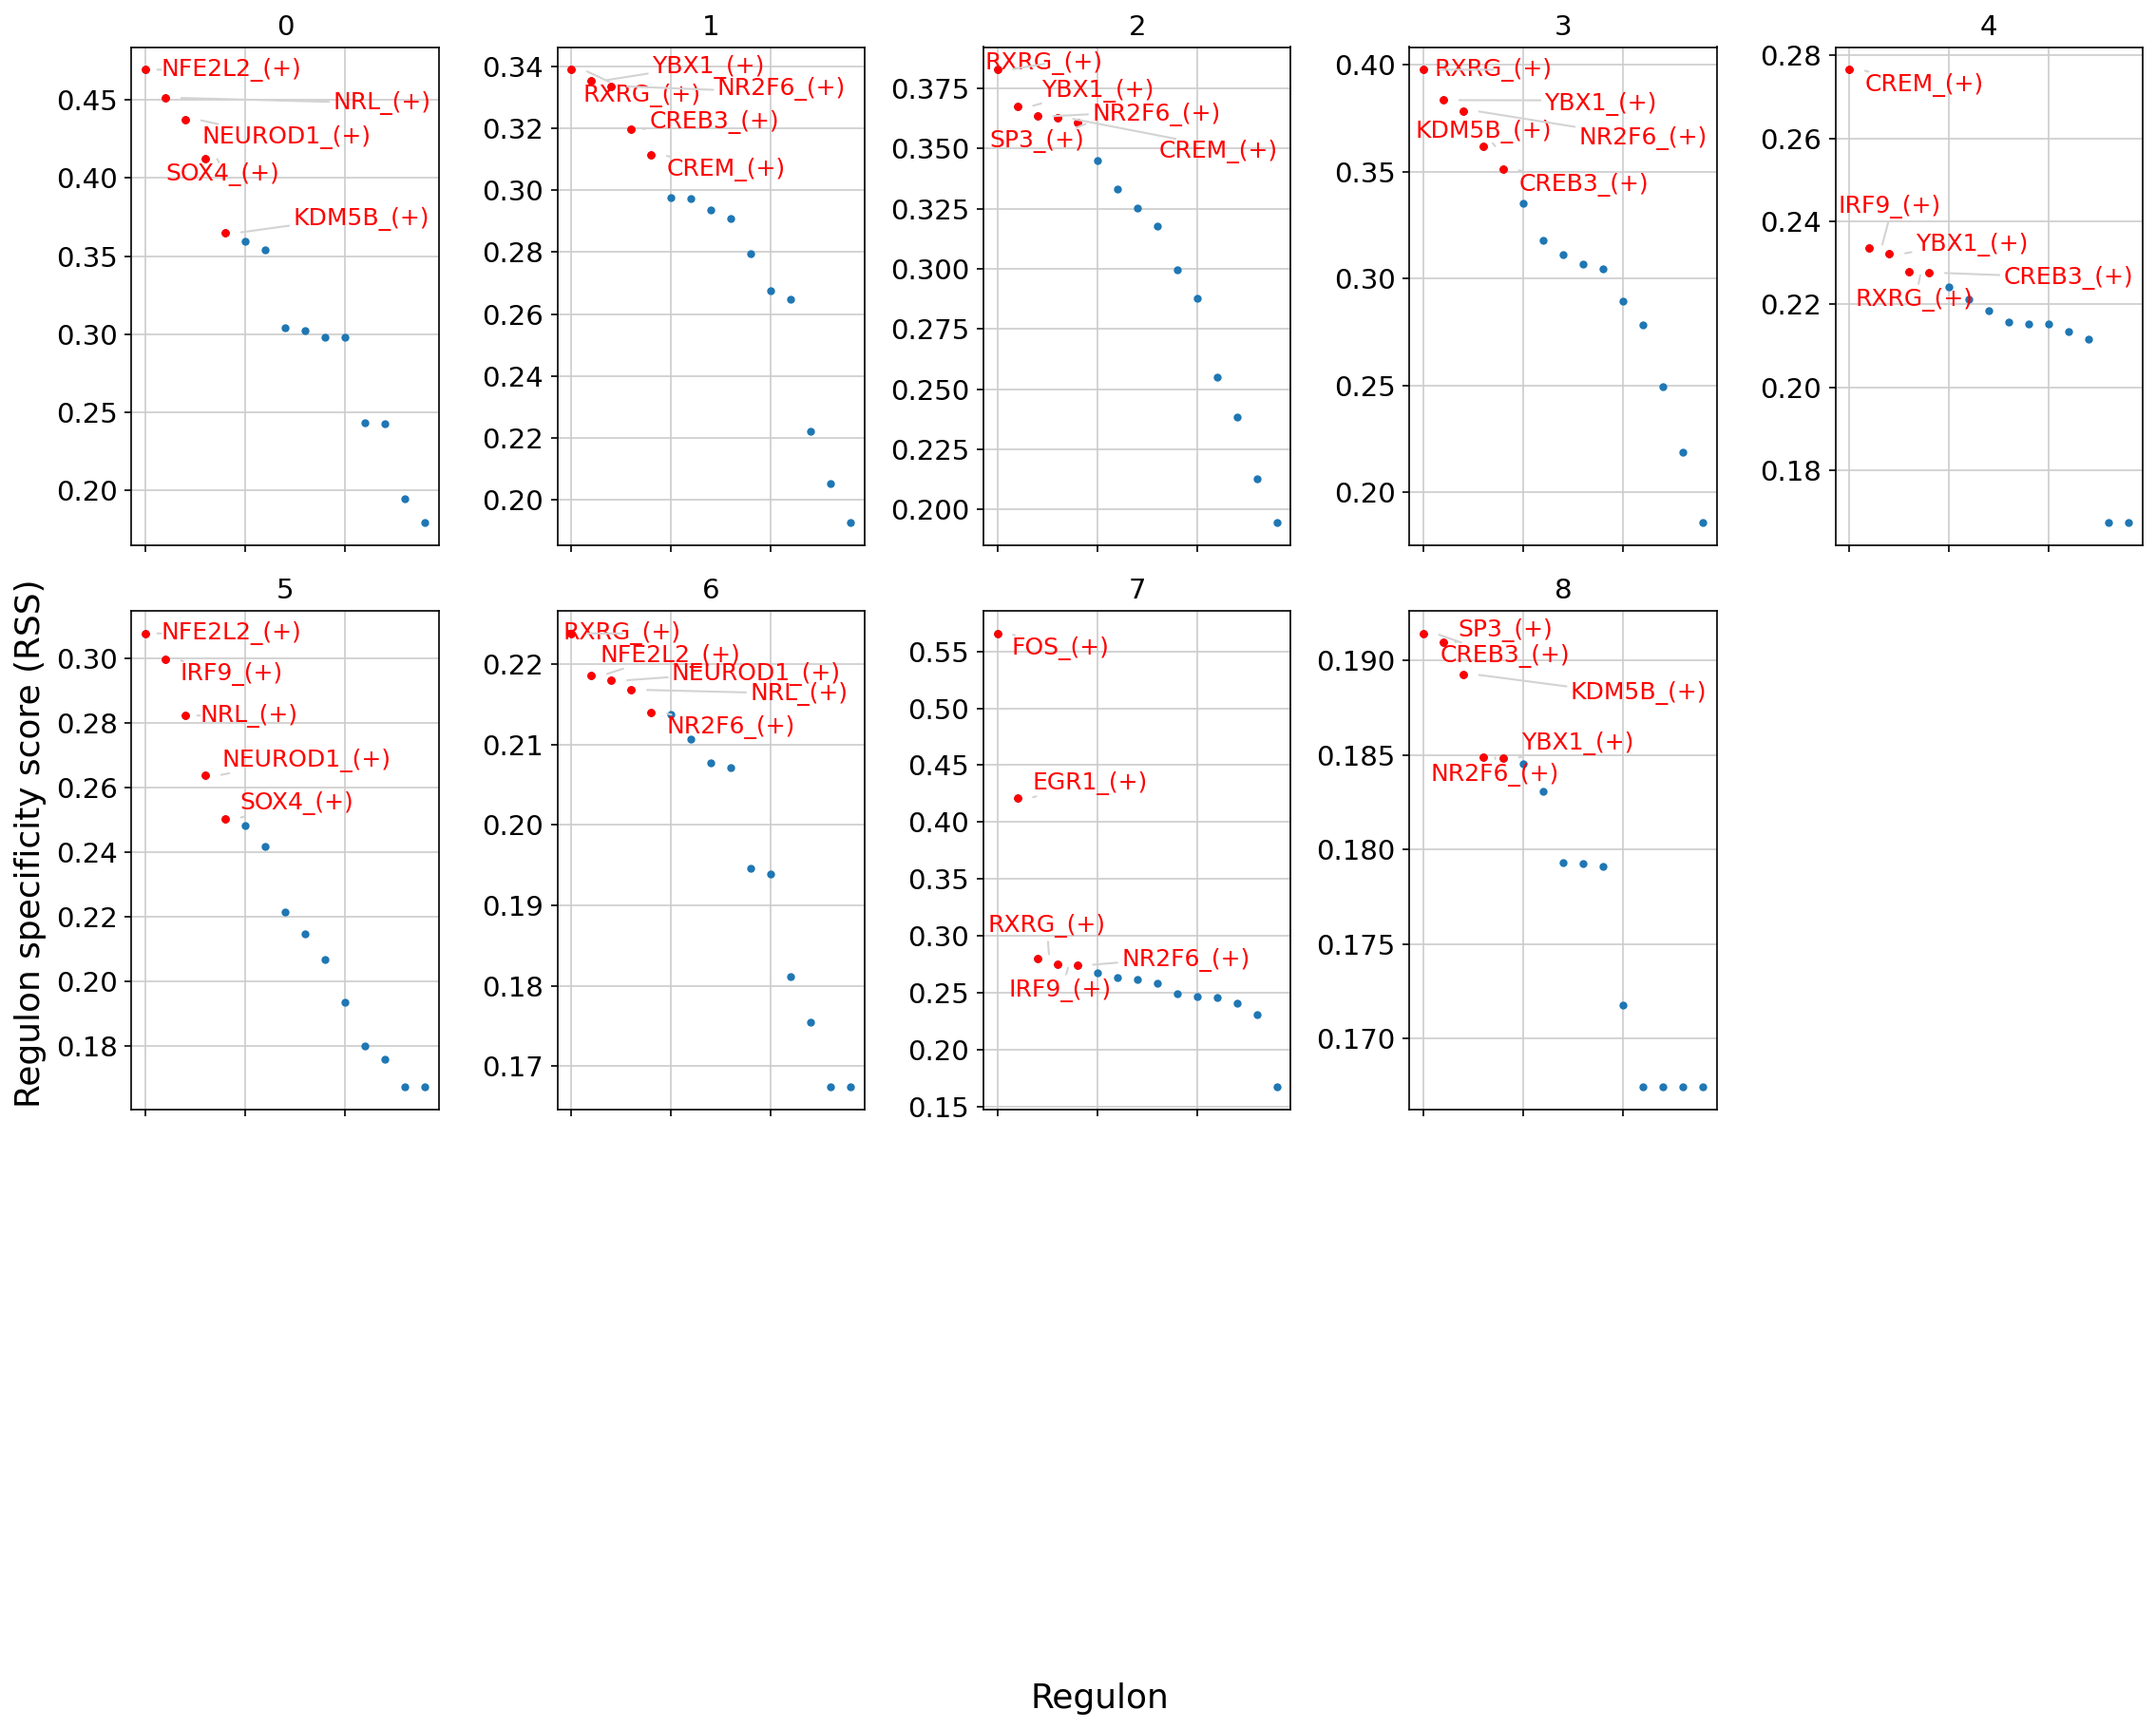

In [38]:
cats = sorted( list(set(cellAnnot[metavar].dropna())) )

fig = plt.figure(figsize=(15, 12))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_louvain.T[c]
    ax = fig.add_subplot(3,5,num)
    plot_rss(rss_louvain, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("PBMC10k_Louvain-RSS-top5.png", dpi=150, bbox_inches = "tight")
plt.show()

### Select the top 5 regulons from each louvain cluster

In [39]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_louvain.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

# Calculate mean AUC per cluster

In [40]:
topreg
auc_meta = pd.merge(adata.obs, auc_mtx, how = "left", left_index = True, right_index = True)
# adata.obs["integrated_snn_res.1.6"].value_counts()
# auc_mtx
mean_regulon_by_meta = auc_meta.groupby(metavar)[topreg].mean()
mean_regulon_by_meta

,YBX1_(+),NRL_(+),NEUROD1_(+),NR2F6_(+),SP3_(+),EGR1_(+),CREB3_(+),KDM5B_(+),SOX4_(+),RXRG_(+),IRF9_(+),FOS_(+),NFE2L2_(+),CREM_(+)
gene_snn_res.1.6,,,,,,,,,,,,,,
0,0.269363,0.440103,0.298799,0.121696,0.045924,0.033422,0.094690,0.066808,0.359000,0.128125,0.053617,0.001394,0.322402,0.012058
1,0.440855,0.182167,0.140931,0.204821,0.021567,0.027096,0.088680,0.044207,0.186654,0.425094,0.017024,0.003425,0.108971,0.022759
2,0.431202,0.137313,0.113375,0.197600,0.036089,0.037717,0.083618,0.042503,0.193919,0.443294,0.028918,0.004416,0.063178,0.024635
3,0.448279,0.156182,0.125370,0.204492,0.018887,0.029675,0.082288,0.054689,0.197315,0.454604,0.029677,0.001566,0.087952,0.016915
4,0.437726,0.202186,0.128799,0.176023,0.026520,0.032115,0.090932,0.041214,0.187029,0.376902,0.059789,0.000000,0.144028,0.043152
5,0.234324,0.568697,0.325793,0.139283,0.050036,0.016357,0.079744,0.077682,0.370623,0.061241,0.143908,0.000000,0.493030,0.002855
6,0.402324,0.270604,0.201940,0.190704,0.019102,0.024288,0.076538,0.046439,0.227431,0.479060,0.000000,0.001844,0.191266,0.005269
7,0.362809,0.193338,0.139888,0.213360,0.022587,0.154034,0.094530,0.055496,0.237194,0.454437,0.067109,0.107864,0.121392,0.019340
8,0.305491,0.120827,0.118468,0.143926,0.035771,0.006680,0.100785,0.054589,0.182805,0.173348,0.000000,0.000000,0.078970,0.000000


#### Generate a Z-score for each regulon to enable comparison between regulons

In [41]:
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

#### Generate a heatmap

In [42]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [43]:
cellAnnot = cellAnnot.sort_values(metavar)
cellAnnot.index

Index(['shl20171031-209', 'shl20171031-035', 'shl20171031-206',
       'shl20171031-208', 'shl20171031-215', 'shl20171031-221',
       'shl20171031-223', 'shl20171031-296', 'shl20171031-309',
       'shl20171031-313',
       ...
       'shl20171031-010', 'shl20171031-003', 'shl20171031-006',
       'shl20171031-005', 'shl20171031-004', 'shl20171031-002',
       'shl20171031-016', 'shl20171031-009', 'shl20171031-492',
       'shl20171031-392'],
      dtype='object', length=152)

In [44]:
auc_mtx = auc_mtx.reindex(cellAnnot.index)

In [45]:
cats

['0', '1', '2', '3', '4', '5', '6', '7', '8']

In [46]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot[metavar].dropna() ]

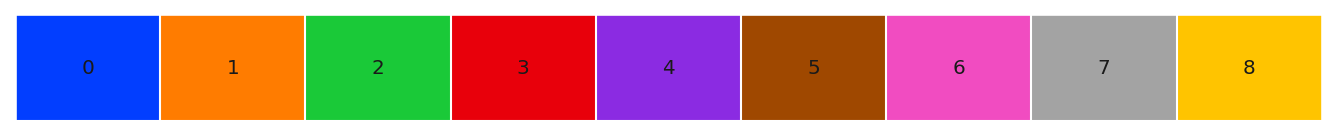

In [47]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)

Text(0.5, -142.80833333333342, '')

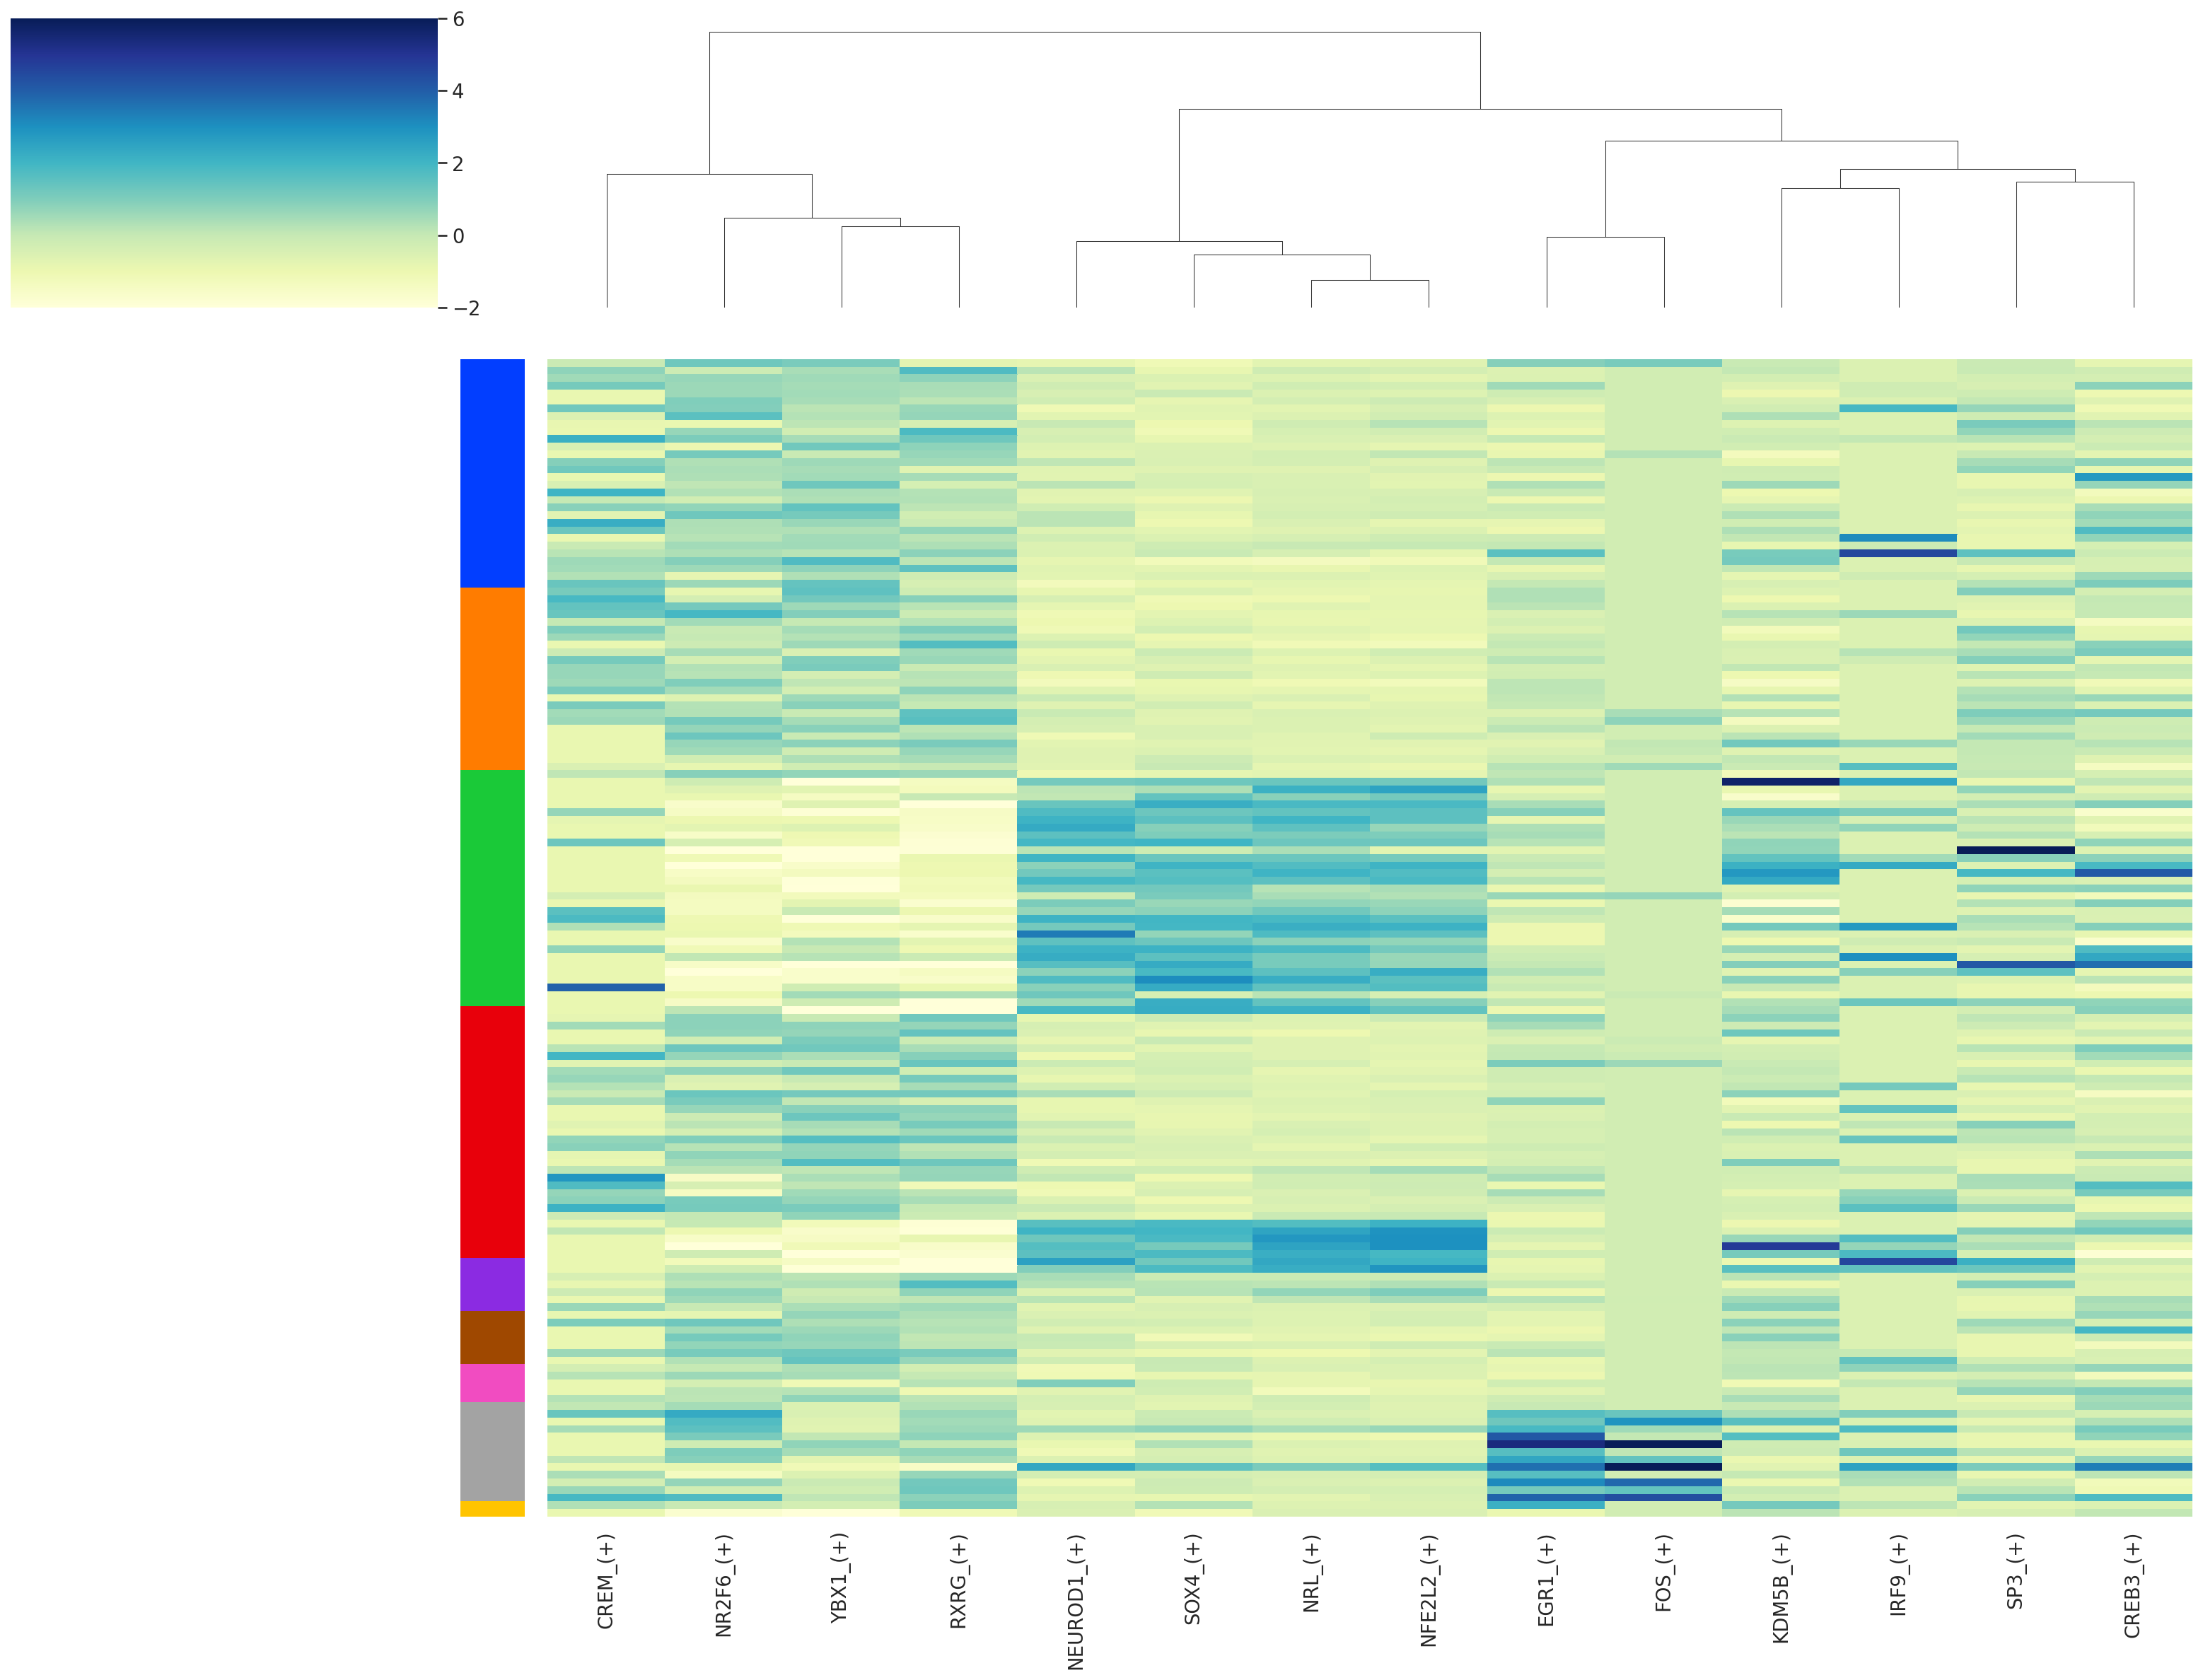

In [48]:
# change row_cluster argument to cluster by ward or else order by specified cell metadata (whatever is currently assigned to metavar)

sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], mask=False,  square=False,  linecolor='gray',
    yticklabels=False, vmin=-2, vmax=6, row_colors=colormap, row_cluster=False, method = 'ward',
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')    
g.ax_heatmap.set_xlabel('')    

In [49]:
g.savefig('scenic_heatmap.png', dpi=600, bbox_inches='tight')

### Generate a binary regulon activity matrix:

In [50]:
from timeit import default_timer as timer
from datetime import timedelta

start = timer()
end = timer()
print(timedelta(seconds=end-start))

0:00:00.000016


In [51]:
binary_mtx, auc_thresholds = binarize(auc_mtx, num_workers=6)
binary_mtx.head()

,CREB3_(+),CREM_(+),EGR1_(+),FOS_(+),IRF9_(+),KDM5B_(+),NEUROD1_(+),NFE2L2_(+),NR2F6_(+),NRL_(+),RXRG_(+),SOX4_(+),SP3_(+),YBX1_(+),ZNF160_(+)
shl20171031-209,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
shl20171031-035,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
shl20171031-206,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
shl20171031-208,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
shl20171031-215,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0


### Show the AUC distributions for selected regulons

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-l

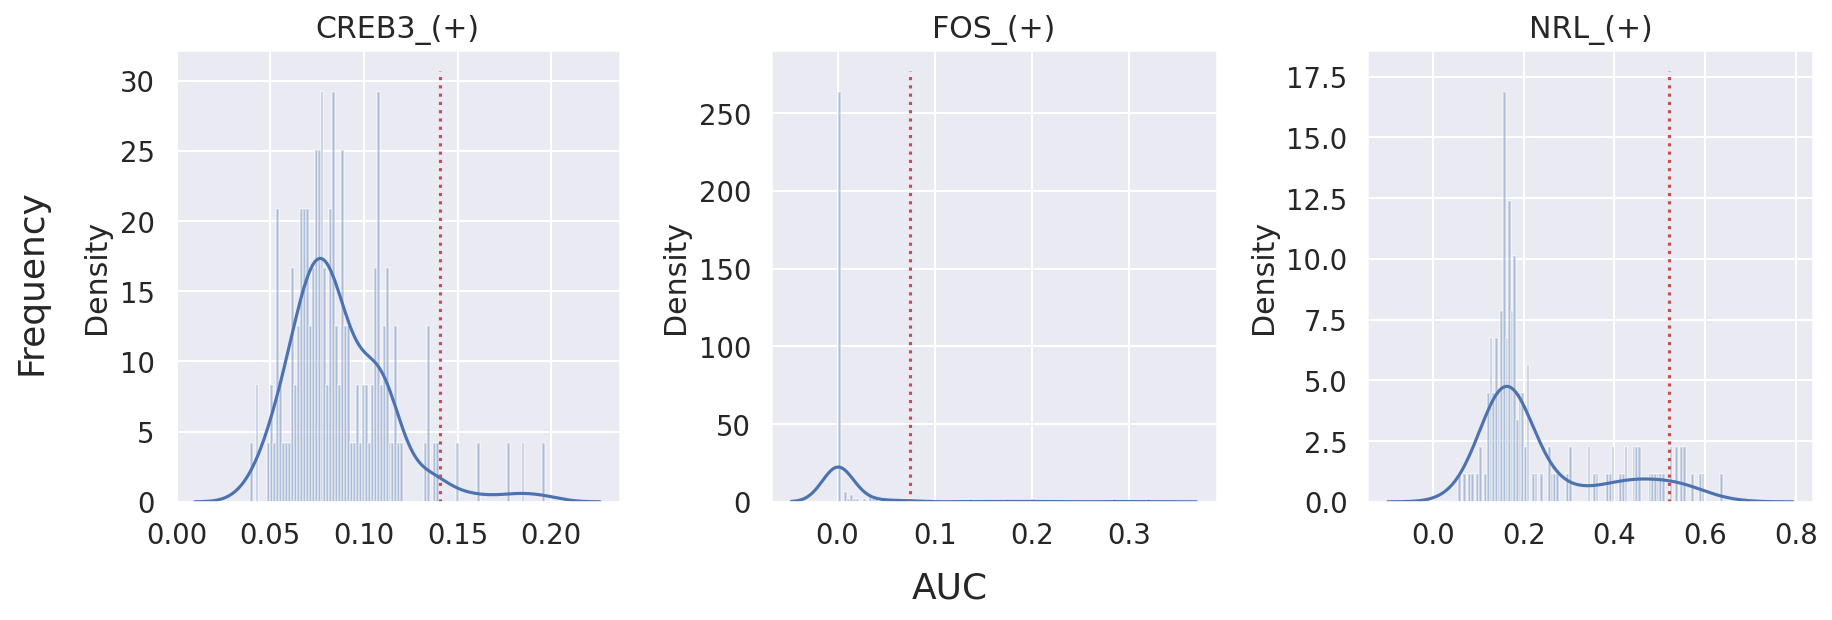

In [52]:
# select regulons:
r = [ 'CREB3_(+)', 'FOS_(+)', 'NRL_(+)' ]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)
for i,ax in enumerate(axs):
    sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
    ax.plot( [ thresholds[ r[i] ] ]*2, ax.get_ylim(), 'r:')
    ax.title.set_text( r[i] )
    ax.set_xlabel('') 
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

fig.tight_layout()
fig.savefig('output/scenic/scenic-binaryPlot.pdf', dpi=600, bbox_inches='tight')

# display regulon scores on umap

In [64]:
adata_h5ad.obs[auc_mtx.columns] = auc_mtx

In [65]:
adata_h5ad.obs

,orig.ident,nCount_RNA,nFeature_RNA,Sample_ID,day,treatment_group,index_i7,i7_bases,index_i5,i5_bases,...,KDM5B_(+),NEUROD1_(+),NFE2L2_(+),NR2F6_(+),NRL_(+),RXRG_(+),SOX4_(+),SP3_(+),YBX1_(+),ZNF160_(+)
shl20171031-110,shl20171031,4.392134e+06,10709,shl20171031_S110,day_5,shCtrl,N718,GGAGCTAC,S508,AGGCTTAG,...,0.052053,0.099576,0.079342,0.243711,0.142965,0.235748,0.150917,0.027638,0.490400,0.0
shl20171031-207,shl20171031,3.588788e+06,10011,shl20171031_S207,day_7,shCtrl,N702,CGTACTAG,S521,TAAGGCTC,...,0.054136,0.189189,0.116504,0.175535,0.210135,0.662276,0.171767,0.029167,0.425951,0.0
shl20171031-210,shl20171031,4.117412e+06,10288,shl20171031_S210,day_7,shCtrl,N703,AGGCAGAA,S515,AGCTAGAA,...,0.044460,0.128511,0.062401,0.215094,0.157671,0.493641,0.198215,0.019628,0.440565,0.0
shl20171031-219,shl20171031,3.557816e+06,10551,shl20171031_S219,day_7,shCtrl,N704,TCCTGAGC,S516,ACTCTAGG,...,0.034839,0.153683,0.119237,0.210839,0.205644,0.428458,0.186771,0.014798,0.433533,0.0
shl20171031-220,shl20171031,2.878420e+06,9632,shl20171031_S220,day_7,shCtrl,N704,TCCTGAGC,S517,TCTTACGC,...,0.024999,0.134499,0.086248,0.212055,0.167687,0.428117,0.232114,0.024459,0.436896,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
shl20171031-013,shl20171031,3.455886e+06,8598,shl20171031_S013,day_0,shCtrl,N702,CGTACTAG,S507,TACTCCTT,...,0.026122,0.073450,0.087540,0.215515,0.171781,0.563366,0.226848,0.020790,0.378623,0.0
shl20171031-014,shl20171031,3.182552e+06,8694,shl20171031_S014,day_0,shCtrl,N702,CGTACTAG,S508,AGGCTTAG,...,0.051532,0.120350,0.113822,0.168428,0.193998,0.574495,0.224927,0.037911,0.364376,0.0
shl20171031-015,shl20171031,1.319803e+05,5831,shl20171031_S015,day_0,shCtrl,N702,CGTACTAG,S510,ATTAGACG,...,0.043939,0.098887,0.100060,0.268073,0.143402,0.498637,0.172927,0.061208,0.398679,0.0
shl20171031-016,shl20171031,2.838621e+06,8472,shl20171031_S016,day_0,shCtrl,N702,CGTACTAG,S511,CGGAGAGA,...,0.087440,0.134499,0.087043,0.180726,0.159062,0.537020,0.259208,0.005014,0.357772,0.0


In [66]:
# mean_regulon_by_meta.loc[:,"CREB3_(+)"]

In [67]:
adata_pca = pd.read_csv("output/scenic/martin_pc_output.csv", index_col = 0)
adata_pca.index

Index(['shl20171031-108', 'shl20171031-109', 'shl20171031-110',
       'shl20171031-111', 'shl20171031-112', 'shl20171031-113',
       'shl20171031-114', 'shl20171031-115', 'shl20171031-116',
       'shl20171031-117',
       ...
       'shl20171031-073', 'shl20171031-074', 'shl20171031-075',
       'shl20171031-076', 'shl20171031-077', 'shl20171031-078',
       'shl20171031-079', 'shl20171031-082', 'shl20171031-083',
       'shl20171031-085'],
      dtype='object', length=260)

In [68]:
adata_pca


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
shl20171031-108,0.873020,-12.721486,-0.325460,14.106707,-21.839247,12.401162,10.503999,-17.742106,17.712895,-6.274862,-30.088492,29.089194,-1.710615,19.499066,-12.335934,56.809554,19.603411,-37.450026,8.153091,18.832069
shl20171031-109,10.840241,-15.206226,1.357469,-14.810697,2.645618,14.914714,3.482755,0.545224,-0.423140,0.067799,0.440087,-1.389072,17.313812,1.962059,-2.028446,-8.290548,3.689760,-14.956871,-9.029420,6.983310
shl20171031-110,-19.828836,-18.595686,14.277158,-6.051873,-13.208516,16.600911,7.394685,0.254216,-16.510703,2.060448,17.668923,10.542829,-8.457423,-6.386715,7.105628,-0.994255,-0.800013,-13.668203,8.092178,4.458131
shl20171031-111,24.955043,-22.122746,17.795515,15.843827,5.050140,-2.538142,15.558785,-30.706708,-6.203651,11.683024,1.148833,-6.550263,-6.651108,-4.033595,7.993120,-11.878926,-26.708855,-8.995833,-10.872142,15.356412
shl20171031-112,13.118467,-7.640759,11.272689,-5.050775,-17.284644,-12.650461,6.464855,5.178937,-7.257570,15.769019,-9.752310,9.053602,13.908164,15.369344,10.048148,-3.798407,1.059421,8.018345,-19.957475,17.220899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
shl20171031-078,51.349676,-12.673233,-15.190145,-11.453399,1.088718,-17.316258,0.246593,-5.311656,13.601551,4.491182,3.985169,-0.331217,0.931155,1.299714,-1.405224,5.435630,1.363153,-2.317721,0.694367,-10.608424
shl20171031-079,42.053168,-12.971528,-16.030952,-16.489032,9.906961,1.438538,-9.155243,-0.302187,11.308591,5.824939,0.097660,-1.265426,-5.564216,-3.555729,-6.227207,1.354678,-0.385110,3.310905,-4.470222,-3.977938
shl20171031-082,-13.964377,-19.647414,-1.328610,-3.424006,-24.704380,12.120819,8.161264,15.361638,-4.228356,-9.553730,-9.907442,21.349961,-6.696083,9.685895,-25.022769,-22.431581,-28.391002,24.777068,24.897232,4.679678
shl20171031-083,18.132591,-35.901464,-6.090797,12.788507,-3.249136,-5.492068,24.629443,-13.135421,-0.584664,2.032823,1.513158,-12.776061,-12.235335,-13.512416,-5.552925,-17.197799,-20.616072,-4.462885,2.156422,1.661514


In [69]:
myindex = adata_h5ad.obs.index

adata_pca0 = adata_pca.reindex(index = myindex)

# adata_pca0 = adata_pca.loc[myindex,]
adata_pca = adata_pca0.to_numpy()

In [70]:
# pd.DataFrame(adata_h5ad.obsm['X_pca']).shape
adata_h5ad.obsm['X_pca'][:,:20] = adata_pca

In [73]:
adata_h5ad.obs.columns

Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sample_ID', 'day',
       'treatment_group', 'index_i7', 'i7_bases', 'index_i5', 'i5_bases',
       'lane', 'branch', 'custom_cluster', 'batch', 'gene_snn_res.0.2',
       'gene_snn_res.0.4', 'gene_snn_res.0.6', 'gene_snn_res.0.8',
       'gene_snn_res.1', 'gene_snn_res.1.2', 'gene_snn_res.1.4',
       'gene_snn_res.1.6', 'gene_snn_res.1.8', 'gene_snn_res.2',
       'seurat_clusters', 'clusters_0.2', 'clusters_0.4', 'clusters_0.6',
       'clusters_0.8', 'clusters_1', 'clusters_1.2', 'clusters_1.4',
       'clusters_1.6', 'clusters_1.8', 'clusters_2', 'S.Score', 'G2M.Score',
       'Phase', 'read_count', 'excluded_because', 'pt2_clusters',
       'pt1_clusters', 'nCount_gene', 'nFeature_gene', 'nCount_transcript',
       'nFeature_transcript', 'transcript_snn_res.0.2',
       'transcript_snn_res.0.4', 'transcript_snn_res.0.6',
       'transcript_snn_res.0.8', 'transcript_snn_res.1',
       'transcript_snn_res.1.2', 'transcript_snn_res

In [74]:
adata_h5ad

AnnData object with n_obs × n_vars = 152 × 56267
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sample_ID', 'day', 'treatment_group', 'index_i7', 'i7_bases', 'index_i5', 'i5_bases', 'lane', 'branch', 'custom_cluster', 'batch', 'gene_snn_res.0.2', 'gene_snn_res.0.4', 'gene_snn_res.0.6', 'gene_snn_res.0.8', 'gene_snn_res.1', 'gene_snn_res.1.2', 'gene_snn_res.1.4', 'gene_snn_res.1.6', 'gene_snn_res.1.8', 'gene_snn_res.2', 'seurat_clusters', 'clusters_0.2', 'clusters_0.4', 'clusters_0.6', 'clusters_0.8', 'clusters_1', 'clusters_1.2', 'clusters_1.4', 'clusters_1.6', 'clusters_1.8', 'clusters_2', 'S.Score', 'G2M.Score', 'Phase', 'read_count', 'excluded_because', 'pt2_clusters', 'pt1_clusters', 'nCount_gene', 'nFeature_gene', 'nCount_transcript', 'nFeature_transcript', 'transcript_snn_res.0.2', 'transcript_snn_res.0.4', 'transcript_snn_res.0.6', 'transcript_snn_res.0.8', 'transcript_snn_res.1', 'transcript_snn_res.1.2', 'transcript_snn_res.1.4', 'transcript_snn_res.1.6', 'transcript_sn

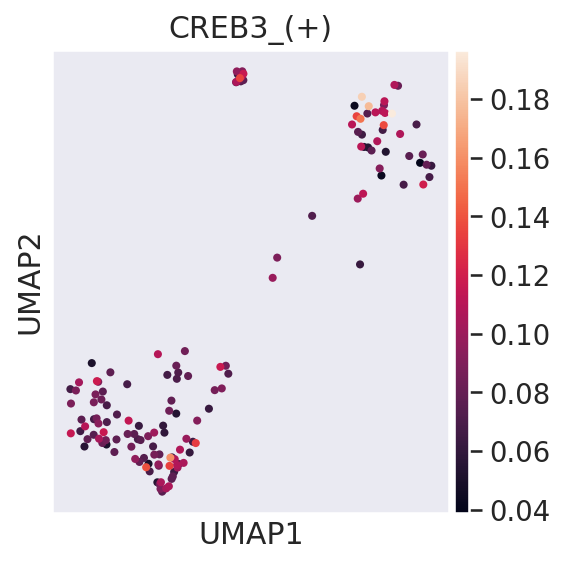

In [78]:
sc.pl.umap(adata_h5ad, color = "CREB3_(+)", size=60, save='.pdf')

/home/skevin/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


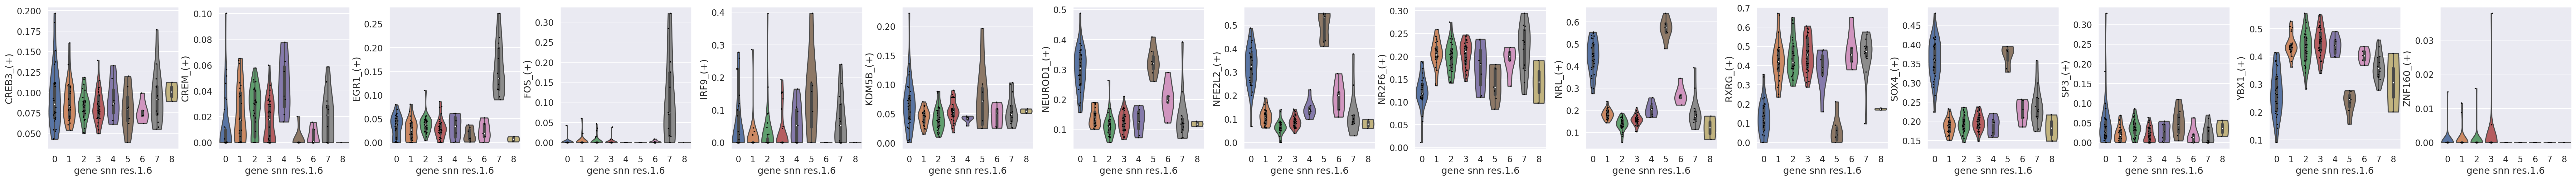

In [80]:
adata_h5ad.obs["gene_snn_res.1.6"]

sc.pl.violin(adata_h5ad, keys=auc_mtx.columns, multi_panel = True, groupby="gene_snn_res.1.6", log=False, stripplot=True, size = 2, inner = "box")

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/scanpy/plotting/_utils.py:289: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/scanpy/plotting/_utils.py:289: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/home/skevin/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


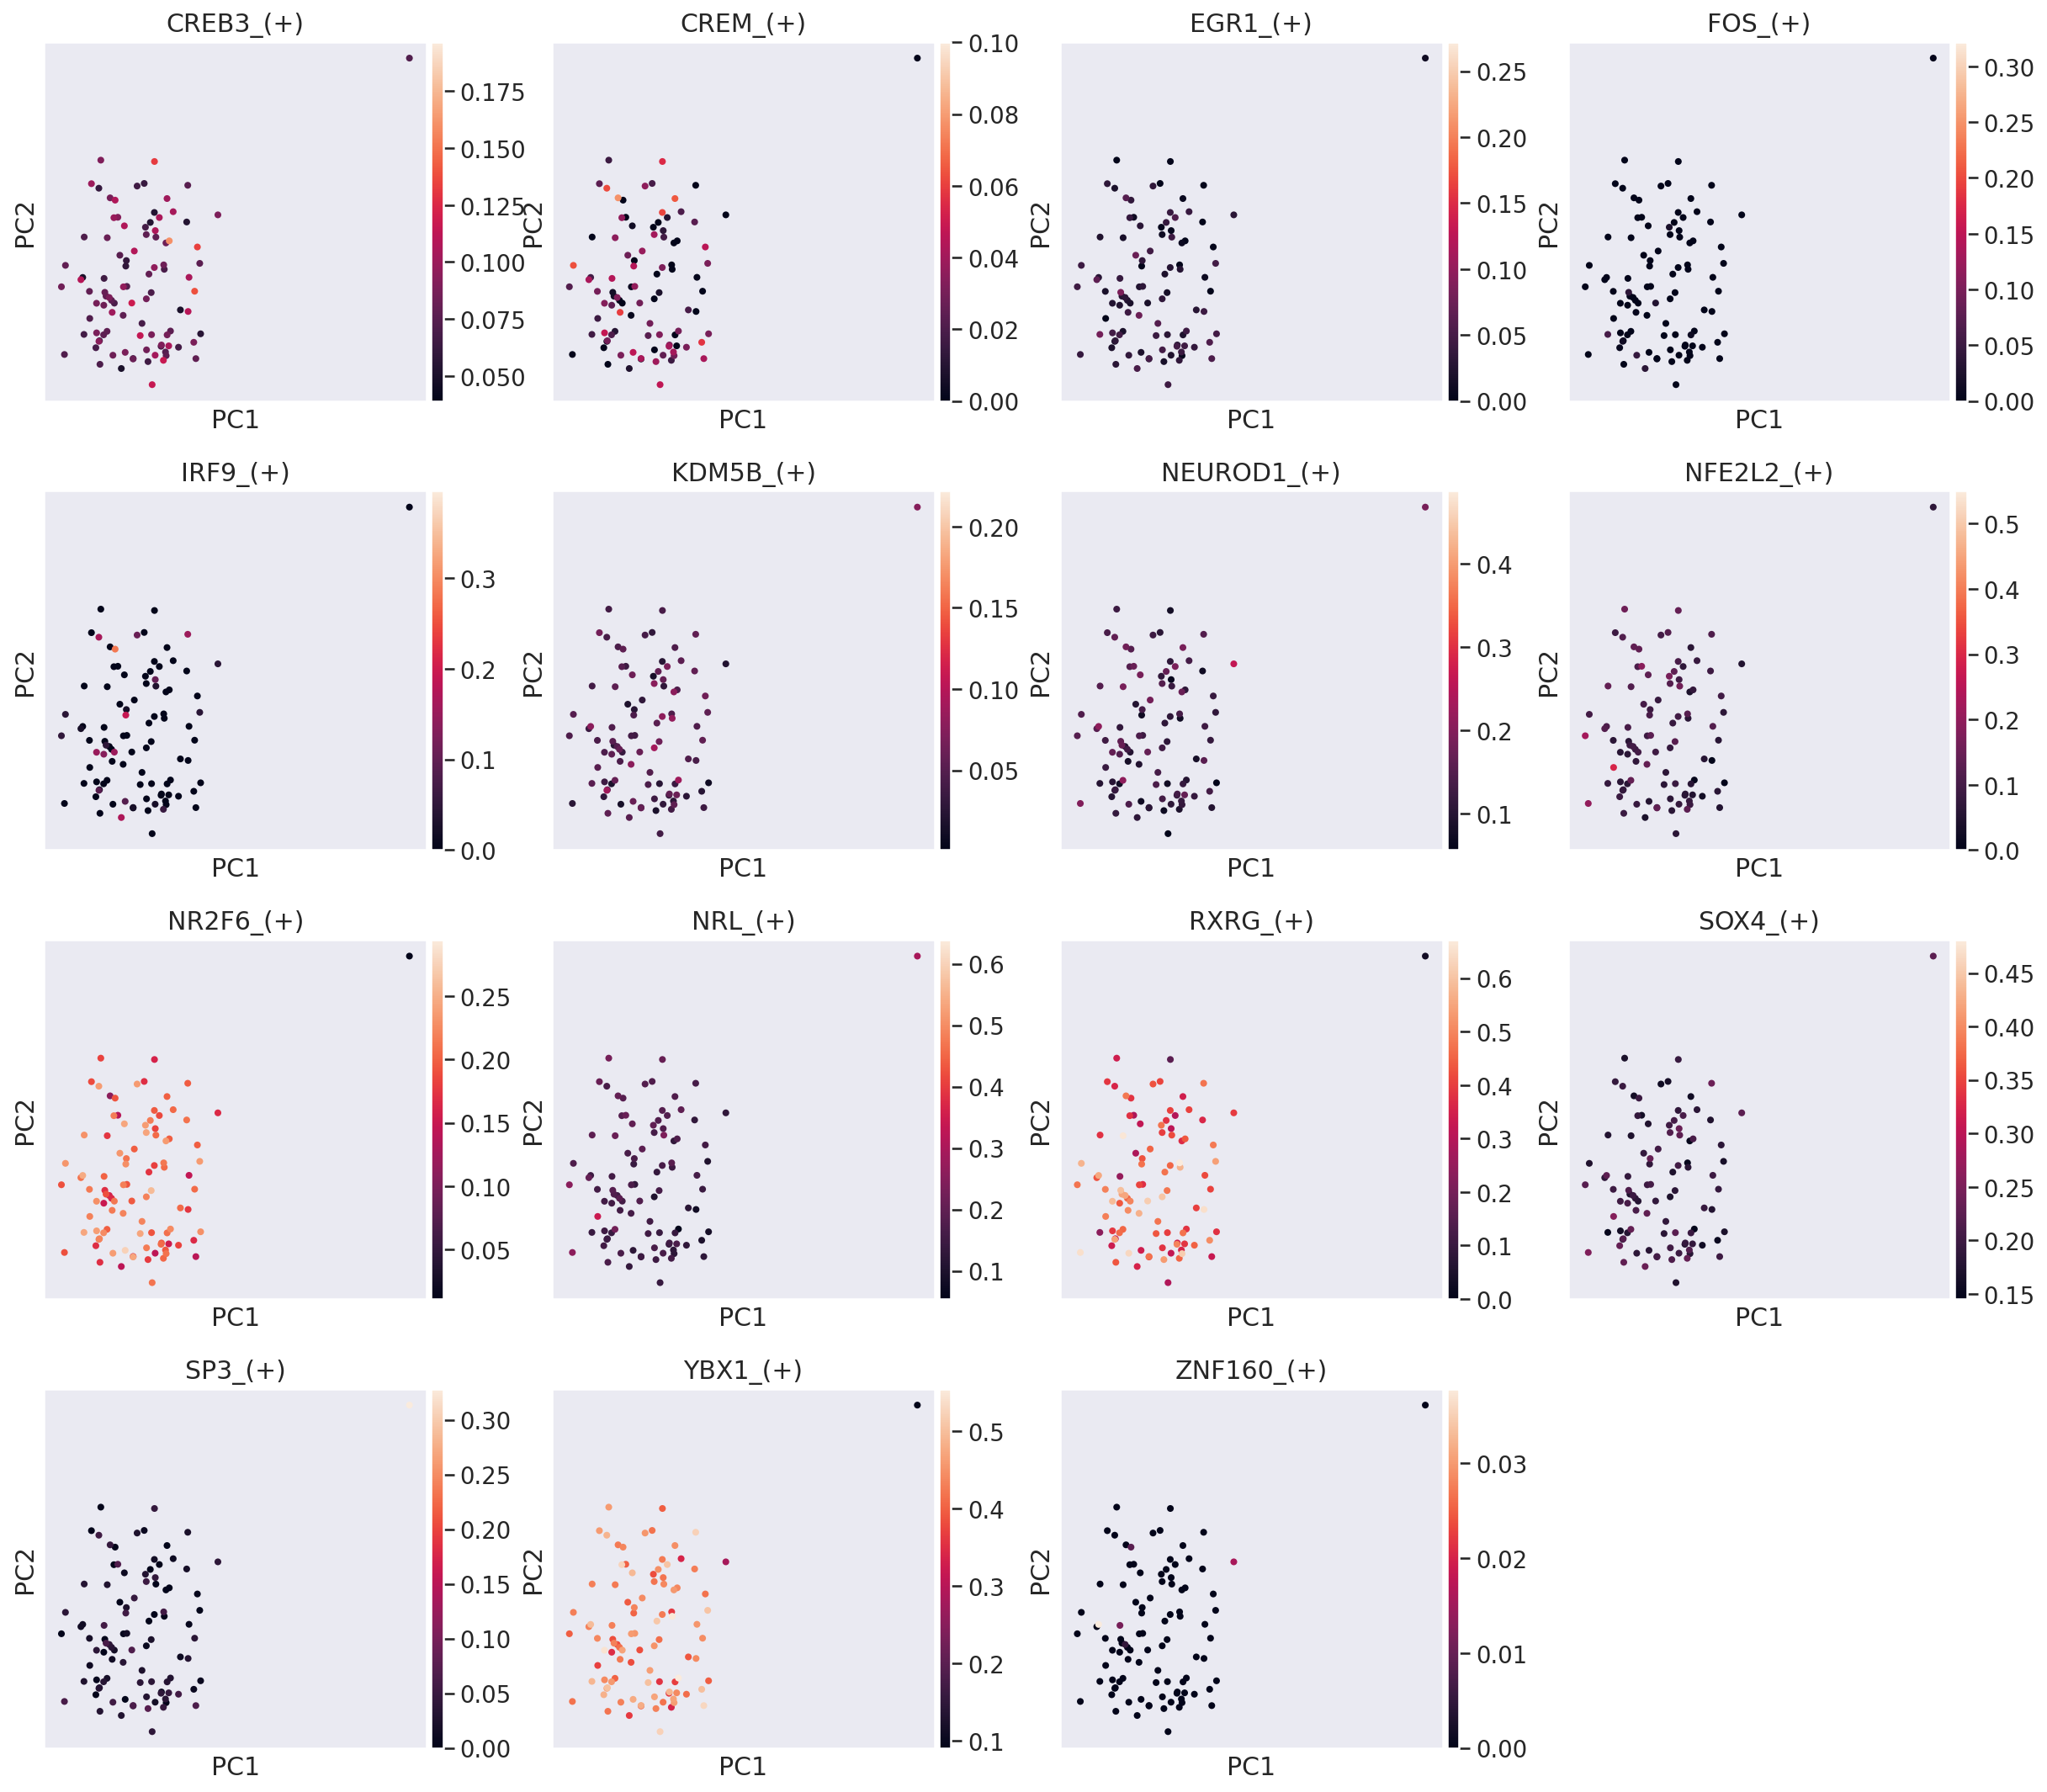

In [81]:
sc.pl.pca(adata_h5ad, components = ['1,2'], color=auc_mtx.columns, size=60, save='.pdf')

/opt/miniconda3/envs/scenic_protocol/lib/python3.6/site-packages/scanpy/plotting/_utils.py:289: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.savefig(filename, dpi=dpi, bbox_inches='tight')
/home/skevin/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


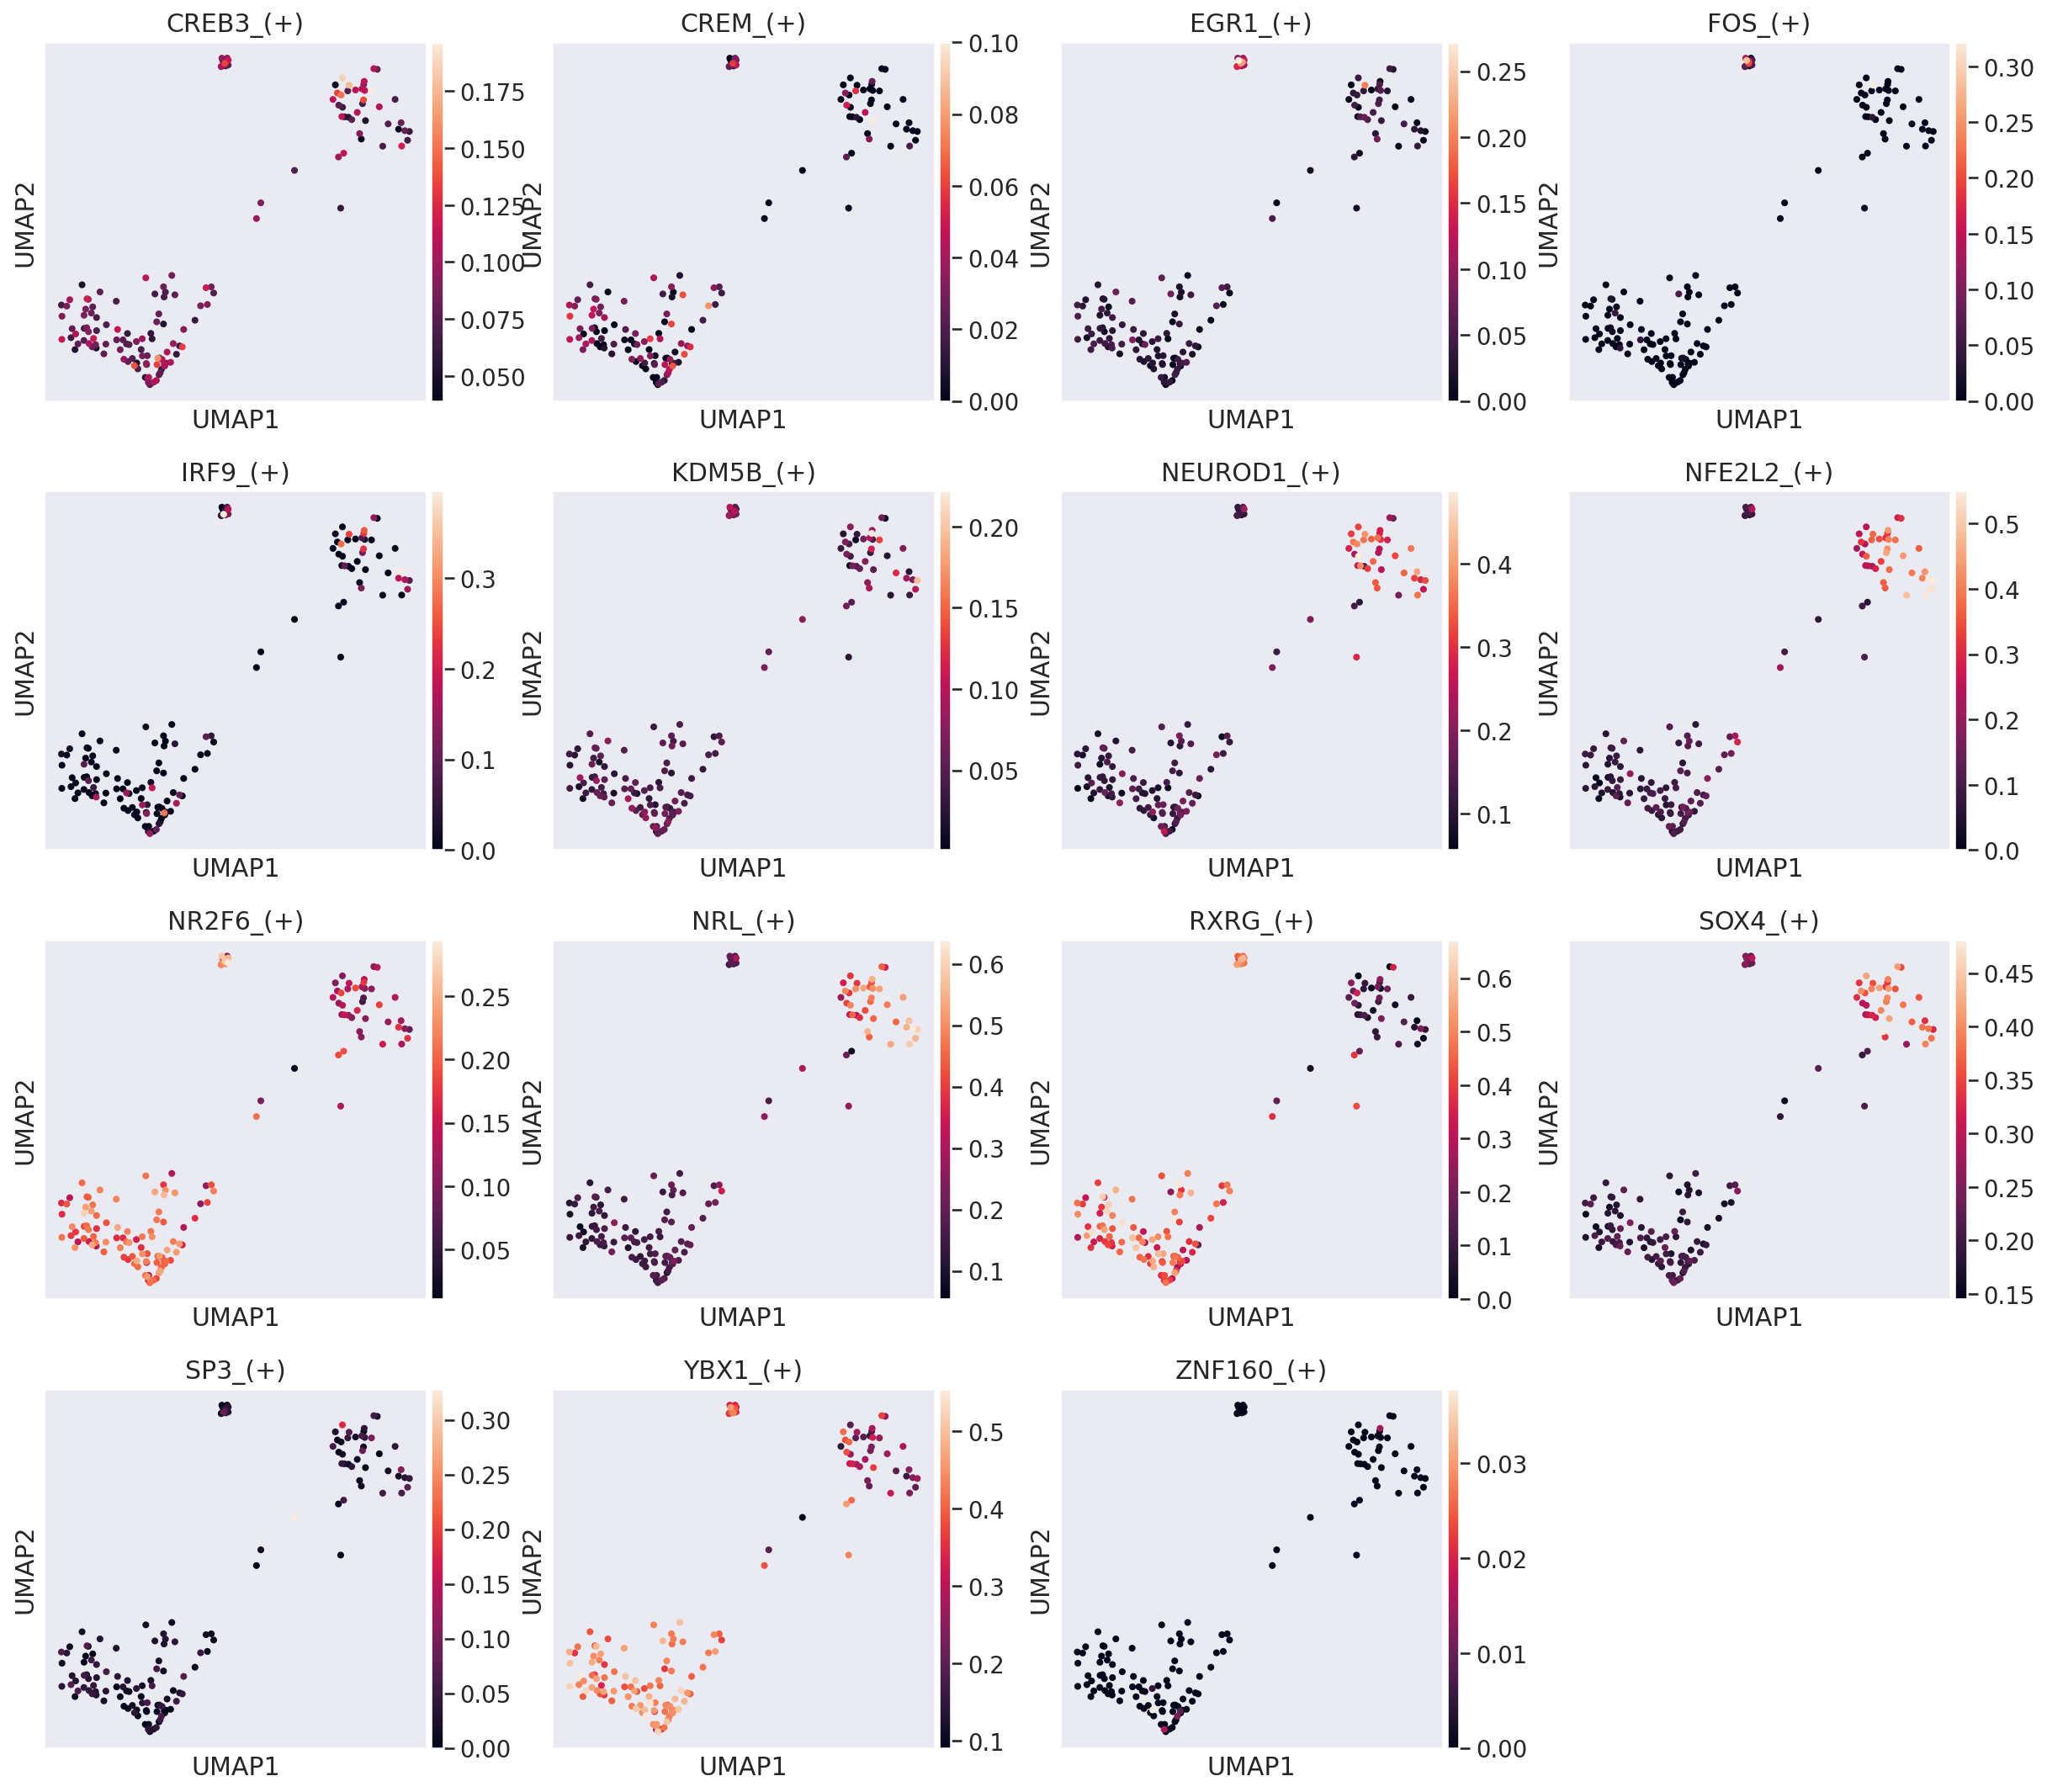

In [82]:
sc.pl.umap(adata_h5ad, color=auc_mtx.columns, size=60, save='.pdf')